# Pogłębiona Analiza Eksploracyjna (EDA) efektywności produkcji pszenicy ozimej

Notebook 02 stanowi kontynuację prac rozpoczętych w Notebooku 01, koncentrując się na zaawansowanej analizie przestrzennej i ekonomicznej zintegrowanego panelu danych.

## Podsumowanie Notebooka 01:
- **Zintegrowano 5 źródeł danych** (plony, nawożenie, ceny pszenicy, pogoda, ceny nawozów) w jeden spójny panel agroekonomiczny
- **Przeprowadzono standaryzację**:
  - Jednostek miar (plony → dt/ha, ceny → zł/kg czystego składnika)
  - Nazw geograficznych i kodów terytorialnych
- **Obliczono kluczowe wskaźniki**:
  - Koszty nawożenia NPK
  - Zysk brutto i wskaźniki efektywności nawożenia
  - Wskaźnik opłacalności produkcji
- **Wykonano podstawową eksplorację**:
  - Macierze korelacji Pearsona i Spearmana
  - Analizę rozkładów i trendów czasowych
  - Porównania międzywojewódzkie

## Zakres analizy w Notebooku 02:

### 1. Analiza przestrzenna efektywności
- Mapy województw dla kluczowych wskaźników:
  - Plony pszenicy
  - Zysk brutto
  - Efektywność nawożenia (N, P, K)
- Identyfikacja regionalnych hot-spotów i cold-spotów

### 2. Analiza temporalna
- Trendy makroekonomiczne (2016-2020):
  - Dynamika plonów vs kosztów nawożenia
  - Zmiany opłacalności produkcji
- Analiza stabilności wskaźników w czasie

### 3. Segmentacja regionów
- Klasteryzacja województw według:
  - Profilu ekonomicznego (zysk, koszty)
  - Efektywności nawożenia
  - Warunków pogodowych
- Weryfikacja różnic między klastrami (ANOVA)

### 4. Przygotowanie do modelowania
- Standaryzacja danych do analiz skupień
- Transformacje zmiennych dla potrzeb algorytmów ML
- Eksport wyników dla Notebooka 03

## Ograniczenia analizy:
- **Dane tylko dla 10 województw** (ograniczenie źródłowych danych GUS)
- **Krótki horyzont czasowy** (5 lat - 2016-2020)

---

Wyniki tej fazy analizy stanowią podstawę dla modeli predykcyjnych i systemu rekomendacji, które zostaną opracowane w Notebooku 03.

In [1]:
# Import niezbędnych bibliotek
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pathlib import Path
from sklearn.metrics import silhouette_score
from scipy.stats import f_oneway

# Ustawienia wykresów
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(font_scale=1.1)

# Ścieżki do katalogów
SCIEZKA_DANYCH = Path("../data")
SCIEZKA_PROCESSED = SCIEZKA_DANYCH / "processed"
SCIEZKA_WYKRESOW = Path("../reports/visualizations")


## 2.1. Wczytanie i szybki podgląd gotowego panelu danych

In [2]:
# Wczytanie panelu agroekonomicznego
df = pd.read_csv(SCIEZKA_PROCESSED / "panel_agroekonomiczny.csv")

print(f"Wymiary panelu: {df.shape[0]} wierszy, {df.shape[1]} kolumn")
print(f"Zakres lat: {df['rok'].min()}-{df['rok'].max()}")
print(f"Liczba województw: {df['wojewodztwo'].nunique()}")
print(f"Województwa w analizie: {', '.join(sorted(df['wojewodztwo'].unique()))}")

Wymiary panelu: 50 wierszy, 25 kolumn
Zakres lat: 2016-2020
Liczba województw: 10
Województwa w analizie: DOLNOŚLĄSKIE, KUJAWSKO-POMORSKIE, LUBUSKIE, MAŁOPOLSKIE, OPOLSKIE, POMORSKIE, WARMIŃSKO-MAZURSKIE, WIELKOPOLSKIE, ZACHODNIOPOMORSKIE, ŚLĄSKIE


## 2.2. Obliczanie dodatkowych wskaźników ekonomicznych

In [3]:
# Obliczanie brakujących kosztów
df['Koszt P [zł/ha]'] = df['Nawożenie P [kg/ha]'] * df['Cena P [zł/kg]']
df['Koszt K [zł/ha]'] = df['Nawożenie K [kg/ha]'] * df['Cena K [zł/kg]']
df['Koszt nawożenia NPK [zł/ha]'] = df['Koszt N [zł/ha]'] + df['Koszt P [zł/ha]'] + df['Koszt K [zł/ha]']

# Obliczanie efektywności wszystkich składników
df["Efektywność N [kg plonu/kg N]"] = df["Plon [dt/ha]"] * 10 / df["Nawożenie N [kg/ha]"]
df["Efektywność P [kg plonu/kg P]"] = df["Plon [dt/ha]"] * 10 / df["Nawożenie P [kg/ha]"]
df["Efektywność K [kg plonu/kg K]"] = df["Plon [dt/ha]"] * 10 / df["Nawożenie K [kg/ha]"]

## 2.3. Analiza przestrzenna (mapy województw)

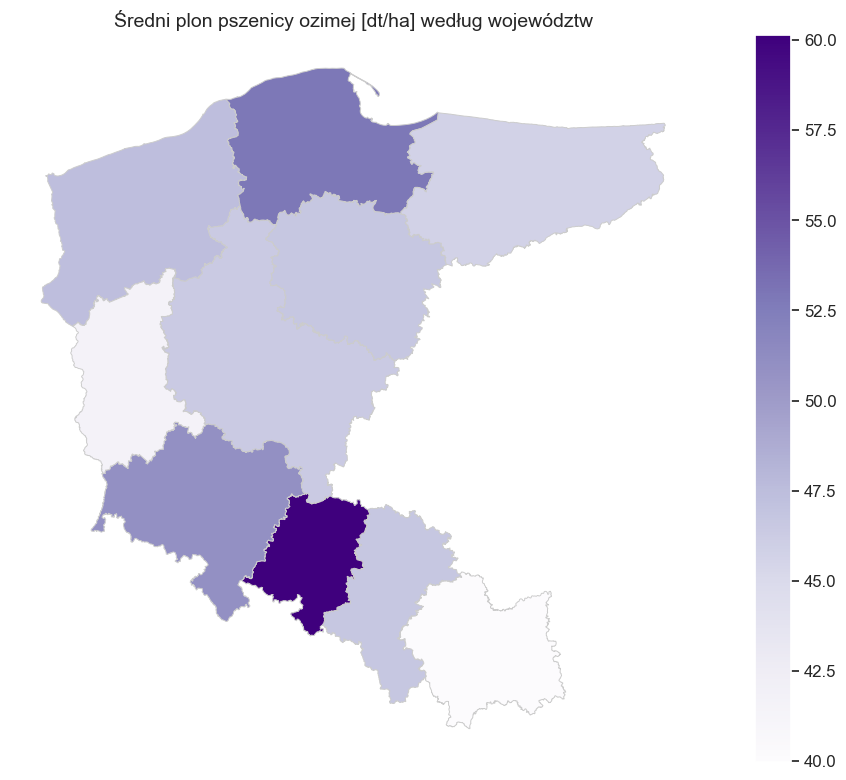

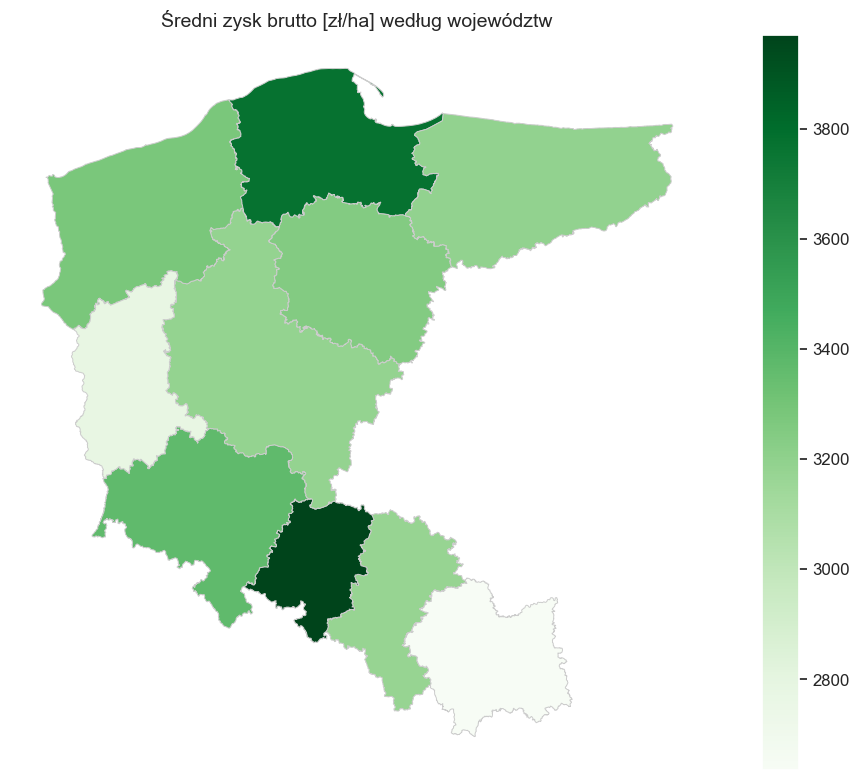

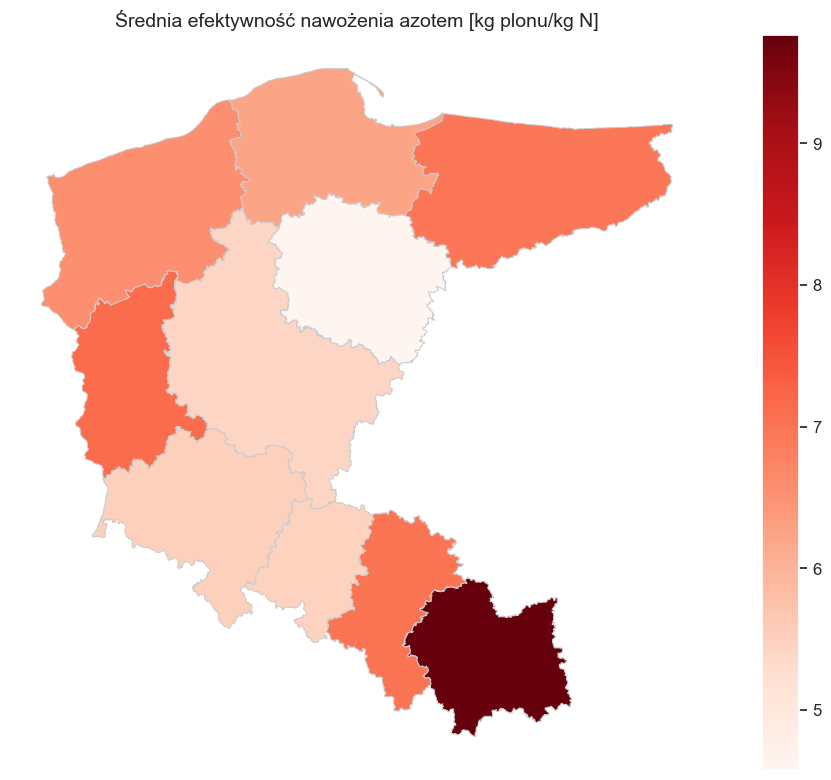

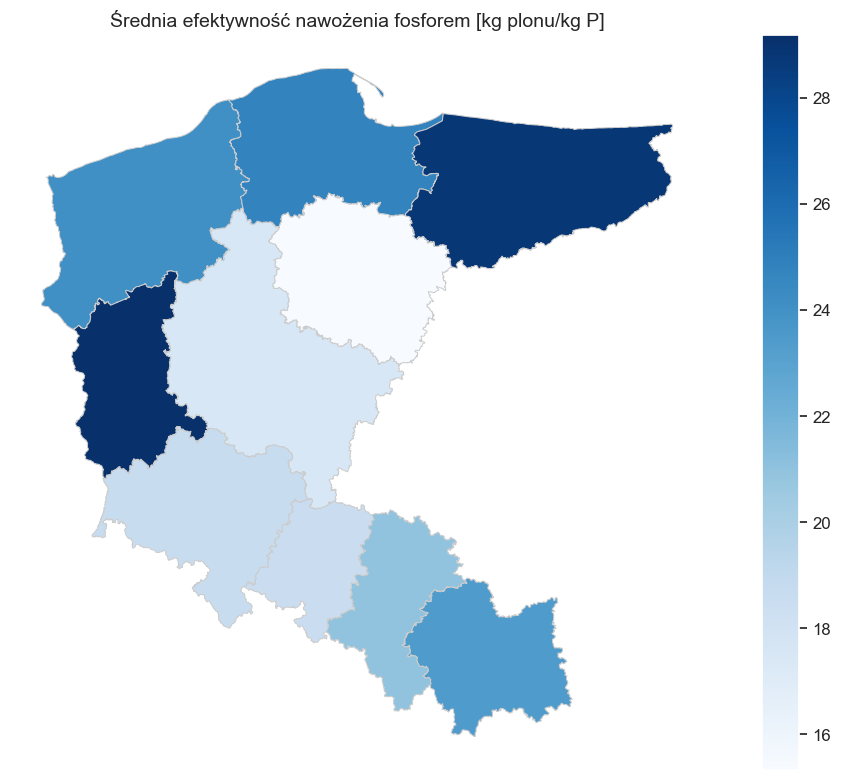

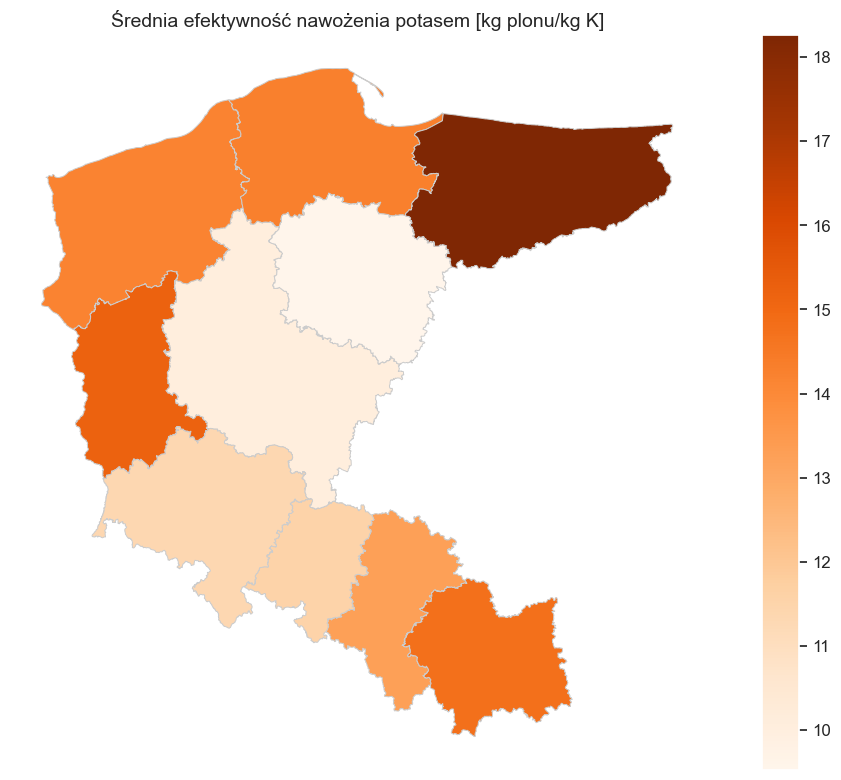

In [4]:
# Przygotowanie tabeli agregującej najważniejsze wskaźniki dla każdego województwa.
df_woj = df.groupby('wojewodztwo').agg({
    'Plon [dt/ha]': 'mean',
    'Zysk brutto [zł/ha]': 'mean',
    'Efektywność N [kg plonu/kg N]': 'mean',
    'Efektywność P [kg plonu/kg P]': 'mean',
    'Efektywność K [kg plonu/kg K]': 'mean'
}).reset_index()

# Wczytanie pliku ze współrzędnymi geometrycznymi granic województw Polski w formacie GeoJSON
woj_geo = gpd.read_file("https://raw.githubusercontent.com/ppatrzyk/polska-geojson/master/wojewodztwa/wojewodztwa-medium.geojson")

# Sprawdzanie pisowni nazw województw względem danych geometrycznych i w panelu agroekonomicznym.
woj_geo = woj_geo.rename(columns={"nazwa": "wojewodztwo"})
woj_geo['wojewodztwo'] = woj_geo['wojewodztwo'].str.upper()
df_woj['wojewodztwo'] = df_woj['wojewodztwo'].str.upper()

# Łączenie (merge) – uzyskujemy GeoDataFrame "mapa" z granicami województw i wskaźnikami ekonomicznymi
mapa = woj_geo.merge(df_woj, on="wojewodztwo")


def generuj_mape(kolumna, tytul, cmap, plik):
    # Tworzenie mapy – granice województw z wypełnieniem według wskazanego wskaźnika
    fig, ax = plt.subplots(figsize=(12, 8))
    mapa.plot(
        column=kolumna,
        cmap=cmap,
        linewidth=0.7,
        edgecolor='0.8',
        legend=True,
        ax=ax
    )
    # Ustawienia tytułu i wyłączenie osi współrzędnych
    ax.set_title(tytul, fontsize=14)
    ax.set_axis_off()
    plt.tight_layout()
    # Zapis wykresu do pliku PNG w repozytorium projektu
    plt.savefig(SCIEZKA_WYKRESOW / plik, dpi=300, bbox_inches="tight")
    plt.show()

# Mapa średniego plonu pszenicy ozimej według województw.
generuj_mape(
    'Plon [dt/ha]',
    'Średni plon pszenicy ozimej [dt/ha] według województw',
    'Purples',
    'mapa_plonow.png'
)

# Mapa średniego zysku brutto z produkcji pszenicy w przeliczeniu na jeden hektar
generuj_mape(
    'Zysk brutto [zł/ha]',
    'Średni zysk brutto [zł/ha] według województw',
    'Greens',
    'mapa_zysk.png'
)

generuj_mape(
    'Efektywność N [kg plonu/kg N]',
    'Średnia efektywność nawożenia azotem [kg plonu/kg N]',
    'Reds',
    'mapa_efektywnosc_n.png'
)

generuj_mape(
    'Efektywność P [kg plonu/kg P]',
    'Średnia efektywność nawożenia fosforem [kg plonu/kg P]',
    'Blues',
    'mapa_efektywnosc_p.png'
)

generuj_mape(
    'Efektywność K [kg plonu/kg K]',
    'Średnia efektywność nawożenia potasem [kg plonu/kg K]',
    'Oranges',
    'mapa_efektywnosc_k.png'
)


## 2.3. Pogłębiona analiza trendów czasowych

In [5]:
# Agregacja danych do analizy trendów
df_rok = df.groupby('rok').agg({
    'Plon [dt/ha]': ['mean', 'std', 'min', 'max'],  # dodajemy statystyki rozproszenia
    'Zysk brutto [zł/ha]': ['mean', 'std', 'min', 'max'],
    'Koszt nawożenia NPK [zł/ha]': 'mean',
    'Efektywność N [kg plonu/kg N]': 'mean',
    'Koszt N [zł/ha]': 'mean',
    'Koszt P [zł/ha]': 'mean',
    'Koszt K [zł/ha]': 'mean',
    'Cena pszenicy [zł/t]': 'mean'
}).reset_index()

# Spłaszczenie wielopoziomowych kolumn
df_rok.columns = ['_'.join(col) if col[1] != '' else col[0] for col in df_rok.columns]

# Lista lat do formatowania osi X
lata = sorted(df_rok['rok'].unique())

### 2.3.1 Trendy ogólnokrajowe - wskaźniki produkcyjne i ekonomiczne

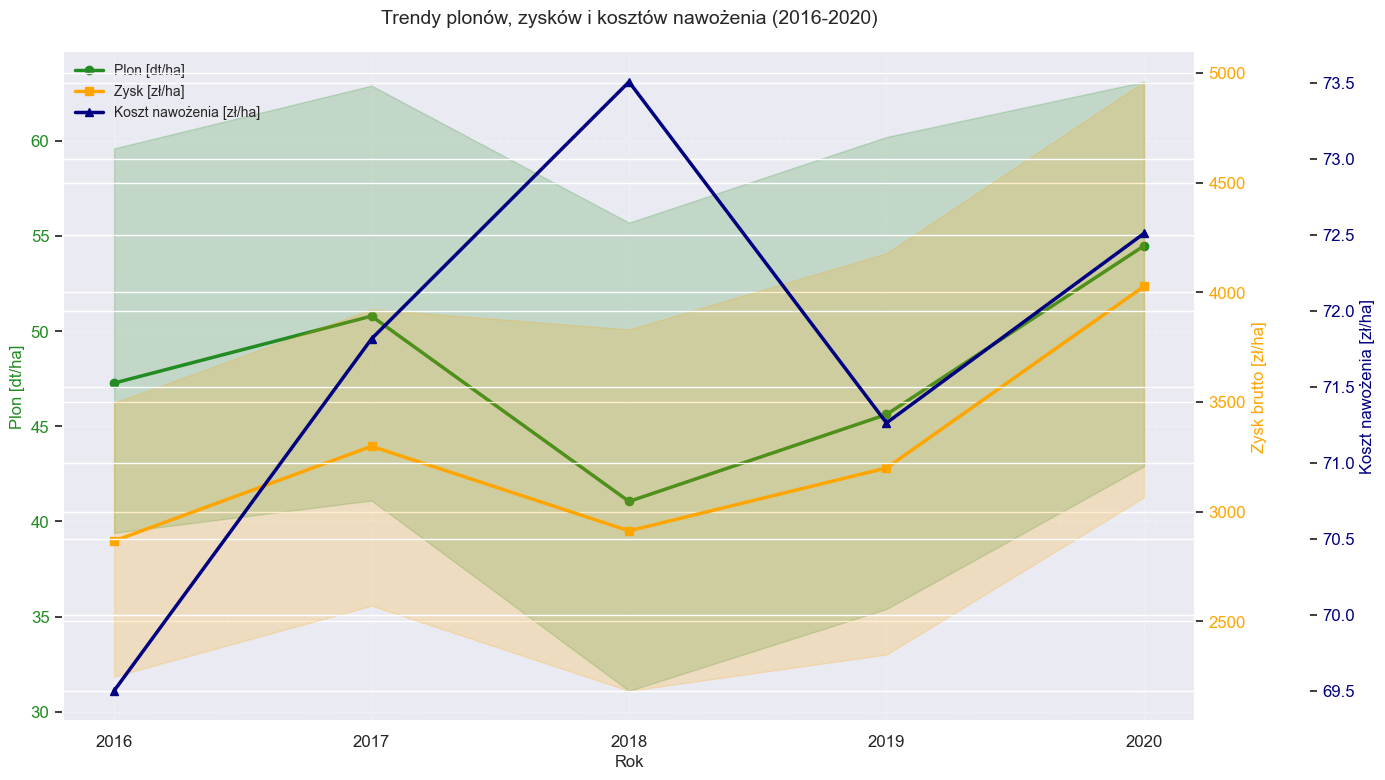

In [6]:
# Elegancki wykres trendów makroekonomicznych
plt.figure(figsize=(14, 8))
ax1 = plt.subplot(111)

# Plon - oś główna
line1 = ax1.plot(df_rok['rok'], df_rok['Plon [dt/ha]_mean'],
          marker='o', color='forestgreen', linewidth=2.5, label='Plon [dt/ha]')
ax1.fill_between(df_rok['rok'],
                df_rok['Plon [dt/ha]_min'], df_rok['Plon [dt/ha]_max'],
                alpha=0.2, color='forestgreen')

# Formatowanie osi lewej
ax1.set_xlabel('Rok', fontsize=12)
ax1.set_ylabel('Plon [dt/ha]', fontsize=12, color='forestgreen')
ax1.tick_params(axis='y', labelcolor='forestgreen')
ax1.set_xticks(lata)
ax1.grid(True, alpha=0.3, linestyle='--')

# Zysk - oś prawa
ax2 = ax1.twinx()
line2 = ax2.plot(df_rok['rok'], df_rok['Zysk brutto [zł/ha]_mean'],
          marker='s', color='orange', linewidth=2.5, label='Zysk [zł/ha]')
ax2.fill_between(df_rok['rok'],
                df_rok['Zysk brutto [zł/ha]_min'], df_rok['Zysk brutto [zł/ha]_max'],
                alpha=0.2, color='orange')

# Formatowanie osi prawej
ax2.set_ylabel('Zysk brutto [zł/ha]', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Koszt nawożenia - druga oś prawa
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
line3 = ax3.plot(df_rok['rok'], df_rok['Koszt nawożenia NPK [zł/ha]_mean'],
          marker='^', color='navy', linewidth=2.5, label='Koszt nawożenia [zł/ha]')
ax3.set_ylabel('Koszt nawożenia [zł/ha]', fontsize=12, color='navy')
ax3.tick_params(axis='y', labelcolor='navy')

# Scalenie legend z wszystkich osi
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

plt.title('Trendy plonów, zysków i kosztów nawożenia (2016-2020)', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig(SCIEZKA_WYKRESOW / "trendy_makroekonomiczne.png", dpi=300, bbox_inches="tight")
plt.show()

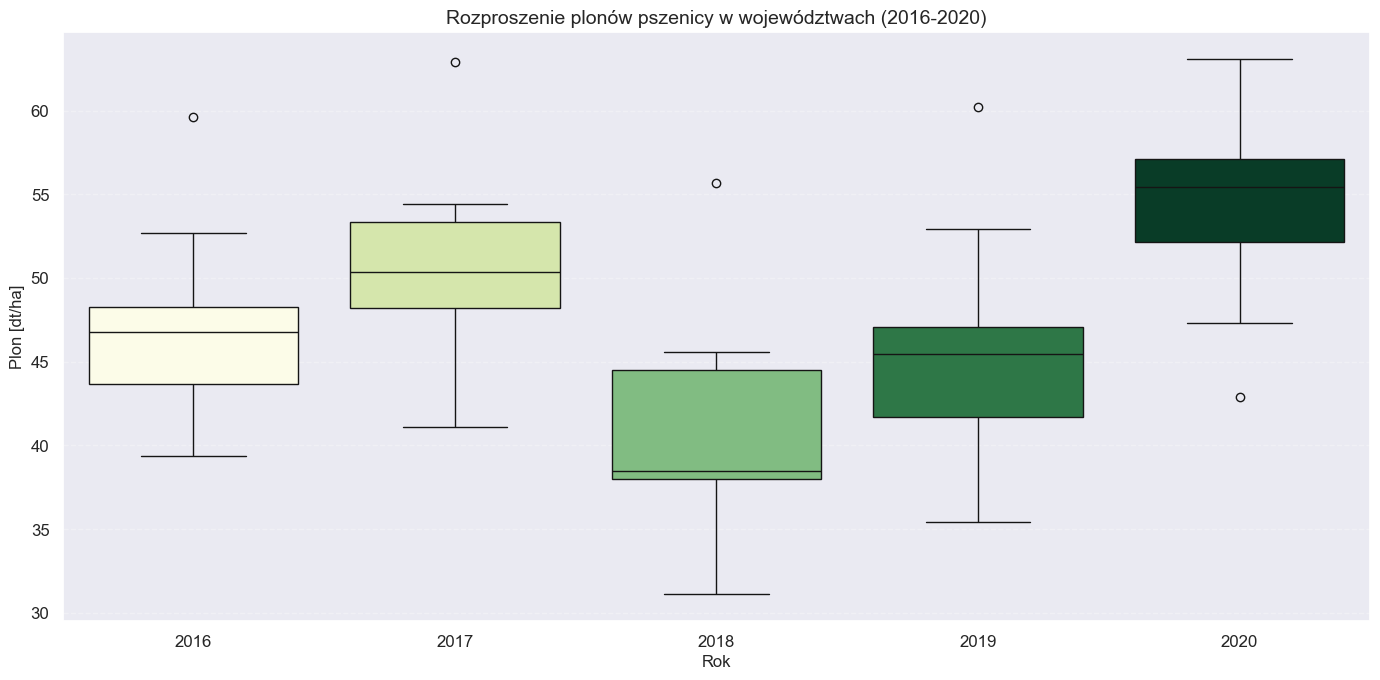

In [7]:
# Rozkład plonów między województwami w kolejnych latach
plt.figure(figsize=(14, 7))
sns.boxplot(x='rok', y='Plon [dt/ha]', data=df, hue='rok', palette='YlGn', legend=False)
plt.title('Rozproszenie plonów pszenicy w województwach (2016-2020)', fontsize=14)
plt.xlabel('Rok', fontsize=12)
plt.ylabel('Plon [dt/ha]', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--', axis='y')
plt.tight_layout()
plt.savefig(SCIEZKA_WYKRESOW / "rozproszenie_plonow.png", dpi=300, bbox_inches="tight")
plt.show()

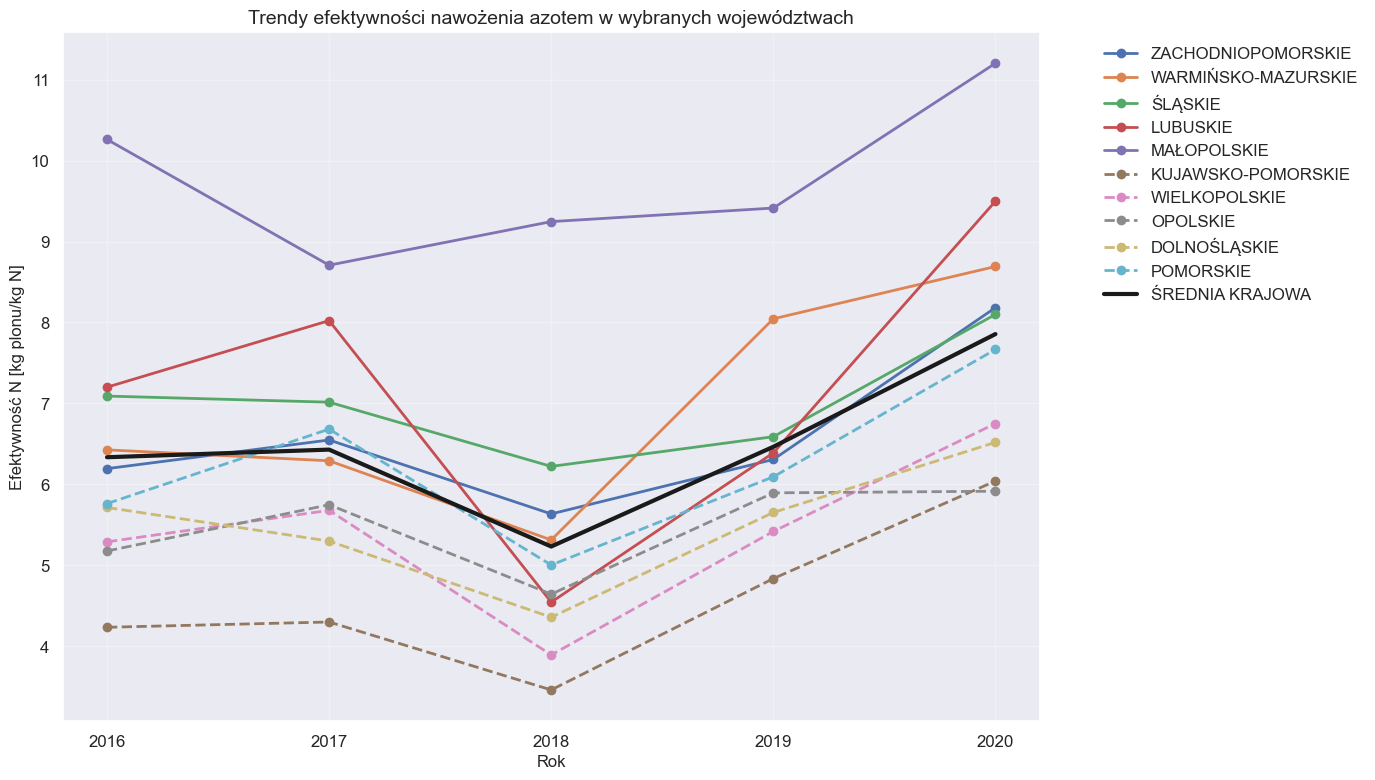

In [8]:
# Trendy efektywności nawożenia w wybranych województwach
plt.figure(figsize=(14, 8))

# Wybierz województwa o najwyższej i najniższej efektywności nawożenia
efektywnosc_N = df.groupby('wojewodztwo')['Efektywność N [kg plonu/kg N]'].mean().sort_values()
top_woj_N = list(efektywnosc_N.tail(5).index)
bottom_woj_N = list(efektywnosc_N.head(5).index)
wybrane_woj_N = top_woj_N + bottom_woj_N

# Wykres dla wybranych województw
for woj in wybrane_woj_N:
    df_woj = df[df['wojewodztwo'] == woj]
    style = '-o' if woj in top_woj_N else '--o'
    plt.plot(df_woj['rok'], df_woj['Efektywność N [kg plonu/kg N]'], style, linewidth=2, label=woj)

# Dodanie średniej krajowej
mean_df = df.groupby('rok')['Efektywność N [kg plonu/kg N]'].mean().reset_index()
plt.plot(mean_df['rok'], mean_df['Efektywność N [kg plonu/kg N]'], 'k-', linewidth=3, label='ŚREDNIA KRAJOWA')

plt.xticks(lata)
plt.title('Trendy efektywności nawożenia azotem w wybranych województwach', fontsize=14)
plt.xlabel('Rok', fontsize=12)
plt.ylabel('Efektywność N [kg plonu/kg N]', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(SCIEZKA_WYKRESOW / "efektywnosc_trendy_woj.png", dpi=300, bbox_inches="tight")
plt.show()

### 2.5.0 Wczytanie danych i podstawowe przygotowanie do klasteryzacji

In [9]:
# Sprawdź dostępne kolumny
print("Dostępne kolumny w danych:")
print(df.columns.tolist())

Dostępne kolumny w danych:
['id', 'wojewodztwo', 'rok', 'Plon [dt/ha]', 'Nawożenie ogółem [kg/ha]', 'Nawożenie N [kg/ha]', 'Nawożenie P [kg/ha]', 'Nawożenie K [kg/ha]', 'cena_pszenicy_dt', 'Cena pszenicy [zł/t]', 'Średnia temperatura [°C]', 'Suma opadów [mm]', 'Dni upalne [liczba]', 'Dni mroźne [liczba]', 'Cena K [zł/kg]', 'Cena N [zł/kg]', 'Cena P [zł/kg]', 'Koszt N [zł/ha]', 'Koszt P [zł/ha]', 'Koszt K [zł/ha]', 'Koszt nawożenia NPK [zł/ha]', 'Przychód [zł/ha]', 'Zysk brutto [zł/ha]', 'Efektywność N [kg plonu/kg N]', 'Wskaźnik opłacalności [%]', 'Efektywność P [kg plonu/kg P]', 'Efektywność K [kg plonu/kg K]']


### 2.5.1 Standaryzacja nazw województw

In [10]:
def standaryzuj_nazwe_wojewodztwa(nazwa):
    zamienniki = {
        'ą': 'a', 'ć': 'c', 'ę': 'e', 'ł': 'l', 'ń': 'n',
        'ó': 'o', 'ś': 's', 'ź': 'z', 'ż': 'z',
        'Ą': 'A', 'Ć': 'C', 'Ę': 'E', 'Ł': 'L', 'Ń': 'N',
        'Ó': 'O', 'Ś': 'S', 'Ź': 'Z', 'Ż': 'Z',
        ' ': '', '-': ''
    }
    nazwa = str(nazwa).lower()
    for znak, zamiennik in zamienniki.items():
        nazwa = nazwa.replace(znak, zamiennik)
    return nazwa.upper()

# Zastosuj do kolumny z województwami
df['wojewodztwo_std'] = df['wojewodztwo'].apply(standaryzuj_nazwe_wojewodztwa)

### 2.5.2 Agregacja danych do poziomu województw

In [11]:
# Słownik agregacji z uwzględnieniem wszystkich wymaganych kolumn
KOLUMNY_AGREGACJI = {
    'Plon [dt/ha]': 'mean',
    'Zysk brutto [zł/ha]': 'mean',
    'Efektywność N [kg plonu/kg N]': 'mean',
    'Efektywność P [kg plonu/kg P]': 'mean',
    'Efektywność K [kg plonu/kg K]': 'mean',
    'Koszt N [zł/ha]': 'mean',
    'Koszt P [zł/ha]': 'mean',
    'Koszt K [zł/ha]': 'mean',
    'Średnia temperatura [°C]': 'mean',
    'Suma opadów [mm]': 'mean',
    'Dni upalne [liczba]': 'mean',
    'Dni mroźne [liczba]': 'mean'
}

# Obliczanie efektywności składników P i K ponownie
df["Efektywność P [kg plonu/kg P]"] = df["Plon [dt/ha]"] * 10 / df["Nawożenie P [kg/ha]"]
df["Efektywność K [kg plonu/kg K]"] = df["Plon [dt/ha]"] * 10 / df["Nawożenie K [kg/ha]"]

# Agregacja z kontrolą błędów
try:
    df_woj = df.groupby('wojewodztwo_std', as_index=False).agg(KOLUMNY_AGREGACJI)
    print("\nDane po agregacji:")
    print(df_woj.head())

except KeyError as e:
    print(f"\nBŁĄD: Brak kolumny {e} w DataFrame. Dostępne kolumny:")
    print(df.columns.tolist())
except Exception as e:
    print(f"\nNieznany błąd: {e}")


Dane po agregacji:
     wojewodztwo_std  Plon [dt/ha]  Zysk brutto [zł/ha]  \
0       DOLNOSLASKIE         50.96          3368.478409   
1  KUJAWSKOPOMORSKIE         46.74          3247.606174   
2           LUBUSKIE         41.58          2777.543231   
3        MALOPOLSKIE         39.98          2634.910539   
4           OPOLSKIE         60.14          3970.704306   

   Efektywność N [kg plonu/kg N]  Efektywność P [kg plonu/kg P]  \
0                       5.510155                      18.665556   
1                       4.576226                      15.328051   
2                       7.131836                      29.186699   
3                       9.765607                      23.407409   
4                       5.477159                      18.548356   

   Efektywność K [kg plonu/kg K]  Koszt N [zł/ha]  Koszt P [zł/ha]  \
0                      11.340095        33.404760        25.847165   
1                       9.525342        31.857598        35.714953   
2           

### 2.5.3 Przygotowanie do klasteryzacji

In [12]:
# Wybór zmiennych do analizy finansowo-efektywnościowej
FEATURES_FINANSOWE = [
    'Zysk brutto [zł/ha]',
    'Efektywność N [kg plonu/kg N]',
    'Efektywność P [kg plonu/kg P]',
    'Efektywność K [kg plonu/kg K]',
    'Koszt N [zł/ha]',
    'Koszt P [zł/ha]',
    'Koszt K [zł/ha]'
]

# Wybór zmiennych pogodowych
FEATURES_POGODOWE = [
    'Średnia temperatura [°C]',
    'Suma opadów [mm]',
    'Dni upalne [liczba]',
    'Dni mroźne [liczba]'
]

# Usuń brakujące wartości (jeśli występują)
df_woj_clean = df_woj.dropna(subset=FEATURES_FINANSOWE + FEATURES_POGODOWE)

### 2.5.4 Klasteryzacja danych finansowych - metoda podwójna

Dla 2 klastrów | WCSS = 31.04
Dla 3 klastrów | WCSS = 21.59
Dla 4 klastrów | WCSS = 15.59
Dla 5 klastrów | WCSS = 9.86
Dla 2 klastrów | Silhouette = 0.3731
Dla 3 klastrów | Silhouette = 0.2507
Dla 4 klastrów | Silhouette = 0.2538
Dla 5 klastrów | Silhouette = 0.2520


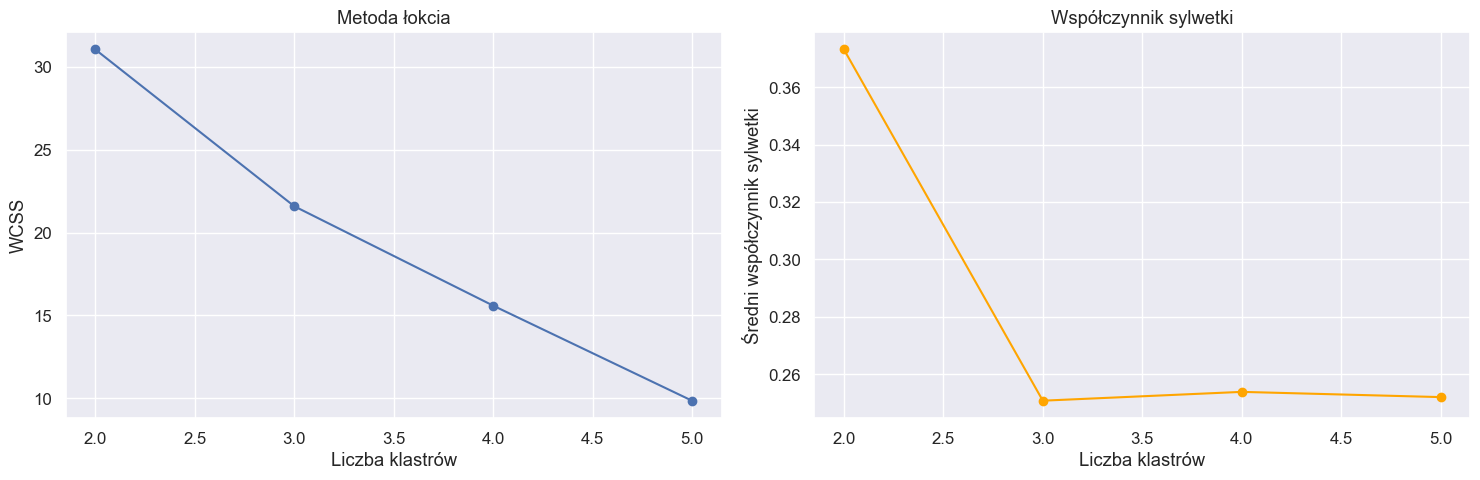

In [13]:
# Standaryzacja danych finansowych
scaler_fin = StandardScaler()
X_fin = scaler_fin.fit_transform(df_woj_clean[FEATURES_FINANSOWE])

# Wspólny zakres dla wszystkich metod
CLUSTER_RANGE = range(2, 6)  # 2-5 klastrów
n_samples = len(df_woj_clean)

# Metoda łokcia
wcss_fin = []
for i in CLUSTER_RANGE:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=20)
    kmeans.fit(X_fin)
    wcss_fin.append(kmeans.inertia_)
    print(f"Dla {i} klastrów | WCSS = {kmeans.inertia_:.2f}")

# Metoda sylwetki
silhouette_fin = []
for i in CLUSTER_RANGE:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=20)
    labels = kmeans.fit_predict(X_fin)
    score = silhouette_score(X_fin, labels)
    silhouette_fin.append(score)
    print(f"Dla {i} klastrów | Silhouette = {score:.4f}")

# Wizualizacja
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Wykres łokcia
ax1.plot(CLUSTER_RANGE, wcss_fin, marker='o')
ax1.set_title('Metoda łokcia')
ax1.set_xlabel('Liczba klastrów')
ax1.set_ylabel('WCSS')

# Wykres sylwetki
ax2.plot(CLUSTER_RANGE, silhouette_fin, marker='o', color='orange')
ax2.set_title('Współczynnik sylwetki')
ax2.set_xlabel('Liczba klastrów')
ax2.set_ylabel('Średni współczynnik sylwetki')

plt.tight_layout()
plt.savefig(SCIEZKA_WYKRESOW / "porownanie_metod.png", dpi=300)
plt.show()


### 2.5.5. Klasteryzacja danych pogodowych - metoda podwójna

Dla 2 klastrów | WCSS = 22.50
Dla 3 klastrów | WCSS = 14.71
Dla 4 klastrów | WCSS = 8.84
Dla 5 klastrów | WCSS = 5.00
Dla 2 klastrów | Silhouette = 0.2607
Dla 3 klastrów | Silhouette = 0.2805
Dla 4 klastrów | Silhouette = 0.2754
Dla 5 klastrów | Silhouette = 0.2545


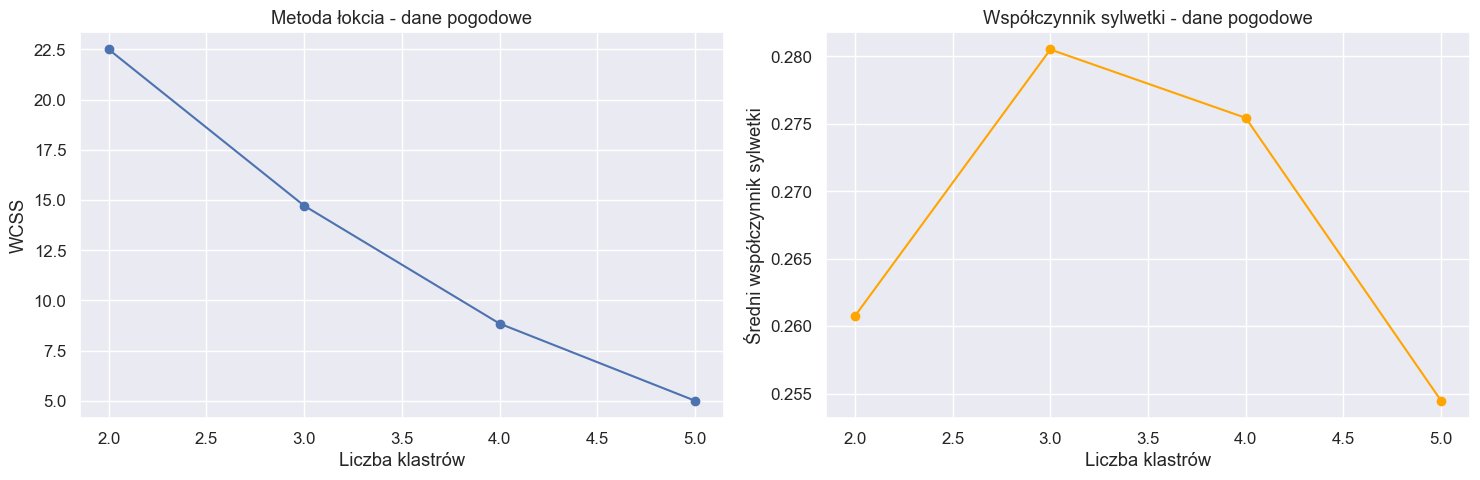

In [14]:
# Standaryzacja danych pogodowych
scaler_pog = StandardScaler()
X_pog = scaler_pog.fit_transform(df_woj_clean[FEATURES_POGODOWE])

# Bezpieczny zakres klastrów
n_samples = len(df_woj_clean)
CLUSTER_RANGE = range(2, 6)

# Metoda łokcia
wcss_pog = []
for i in CLUSTER_RANGE:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=20)
    kmeans.fit(X_pog)
    wcss_pog.append(kmeans.inertia_)
    print(f"Dla {i} klastrów | WCSS = {kmeans.inertia_:.2f}")

# Metoda sylwetki
silhouette_pog = []
for i in CLUSTER_RANGE:
    if i < n_samples:  # Dodatkowe zabezpieczenie
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=20)
        labels = kmeans.fit_predict(X_pog)
        score = silhouette_score(X_pog, labels)
        silhouette_pog.append(score)
        print(f"Dla {i} klastrów | Silhouette = {score:.4f}")

# Wspólna wizualizacja
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Wykres łokcia
ax1.plot(CLUSTER_RANGE, wcss_pog, marker='o')
ax1.set_title('Metoda łokcia - dane pogodowe')
ax1.set_xlabel('Liczba klastrów')
ax1.set_ylabel('WCSS')

# Wykres sylwetki
ax2.plot(CLUSTER_RANGE, silhouette_pog, marker='o', color='orange')
ax2.set_title('Współczynnik sylwetki - dane pogodowe')
ax2.set_xlabel('Liczba klastrów')
ax2.set_ylabel('Średni współczynnik sylwetki')

plt.tight_layout()
plt.savefig(SCIEZKA_WYKRESOW / "porownanie_metod_pogoda.png", dpi=300)
plt.show()

### 2.5.6. Finalna klasteryzacja

In [15]:
# Klasteryzacja finansowa
kmeans_fin = KMeans(n_clusters=3, random_state=42, n_init=20)
df_woj_clean['Klaster_Finansowy'] = kmeans_fin.fit_predict(X_fin)

# Klasteryzacja pogodowa
kmeans_pog = KMeans(n_clusters=3, random_state=42, n_init=20)
df_woj_clean['Klaster_Pogodowy'] = kmeans_pog.fit_predict(X_pog)

print("\nPodsumowanie klasterów finansowych:")
print(df_woj_clean.groupby('Klaster_Finansowy')[FEATURES_FINANSOWE].mean())

print("\nPodsumowanie klasterów pogodowych:")
print(df_woj_clean.groupby('Klaster_Pogodowy')[FEATURES_POGODOWE].mean())


Podsumowanie klasterów finansowych:
                   Zysk brutto [zł/ha]  Efektywność N [kg plonu/kg N]  \
Klaster_Finansowy                                                       
0                          3443.634372                       5.242856   
1                          3409.892072                       6.607099   
2                          2867.304938                       7.950575   

                   Efektywność P [kg plonu/kg P]  \
Klaster_Finansowy                                  
0                                      17.516404   
1                                      23.268754   
2                                      27.130077   

                   Efektywność K [kg plonu/kg K]  Koszt N [zł/ha]  \
Klaster_Finansowy                                                   
0                                      10.623736        34.813696   
1                                      13.916083        29.877226   
2                                      16.083887        22.6

In [16]:
# Przygotowanie geodanych z użyciem istniejącego woj_geo z sekcji 2.3.
if 'wojewodztwo_std' not in woj_geo.columns:
    woj_geo["wojewodztwo_std"] = woj_geo["wojewodztwo"].apply(standaryzuj_nazwe_wojewodztwa)

# Scalanie danych
mapa_klastrow = woj_geo.merge(
    df_woj_clean[["wojewodztwo_std", "Klaster_Finansowy", "Klaster_Pogodowy"]],
    on="wojewodztwo_std",
    how="left"
)


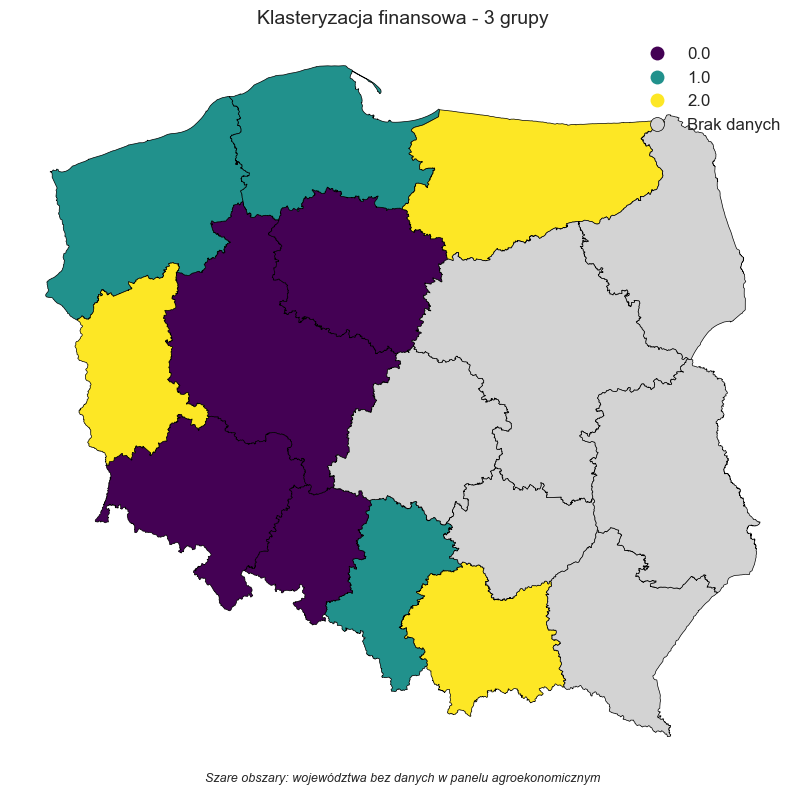

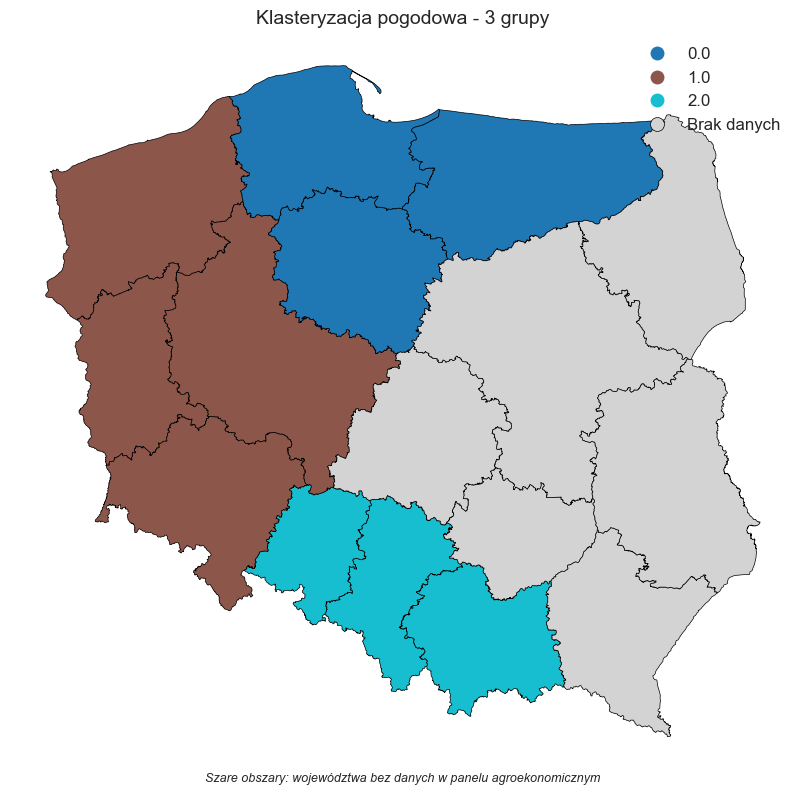

Liczba województw w klastrach finansowych:
Klaster_Finansowy
0.0    4
1.0    3
2.0    3
Name: count, dtype: int64

Liczba województw w klastrach pogodowych:
Klaster_Pogodowy
0.0    3
1.0    4
2.0    3
Name: count, dtype: int64


In [17]:
# Funkcja do wizualizacji danych na mapie
def generuj_mape_klastrow(data, kolumna, tytul, cmap, plik):
    fig, ax = plt.subplots(figsize=(12,8))

    # Dodanie opcji dla brakujących danych (wartość -1)
    data.plot(
        column=kolumna,
        categorical=True,
        cmap=cmap,
        legend=True,
        edgecolor="black",
        linewidth=0.5,
        missing_kwds={'color': 'lightgray', 'label': 'Brak danych'},  # Wyraźne oznaczenie
        ax=ax
    )
    ax.set_title(tytul, fontsize=14)
    ax.set_axis_off()

    # Dodanie objaśnienia o brakujących danych
    plt.figtext(0.5, 0.01, "Szare obszary: województwa bez danych w panelu agroekonomicznym",
                ha="center", fontsize=9, style='italic')

    plt.tight_layout()
    plt.savefig(SCIEZKA_WYKRESOW / plik, dpi=300, bbox_inches="tight")
    plt.show()

# Generowanie map
generuj_mape_klastrow(mapa_klastrow,
                     "Klaster_Finansowy",
                     "Klasteryzacja finansowa - 3 grupy",
                     "viridis",
                     "mapa_klastrow_finansowe_final.png")

generuj_mape_klastrow(mapa_klastrow,
                     "Klaster_Pogodowy",
                     "Klasteryzacja pogodowa - 3 grupy",
                     "tab10",
                     "mapa_klastrow_pogodowe_final.png")

# Raport statystyczny z podziałem na klastry
print("Liczba województw w klastrach finansowych:")
print(mapa_klastrow["Klaster_Finansowy"].value_counts().sort_index())
print("\nLiczba województw w klastrach pogodowych:")
print(mapa_klastrow["Klaster_Pogodowy"].value_counts().sort_index())

### 2.5.7. Analiza wariancji (ANOVA) między klastrami

In [18]:
# Analiza wariancji (ANOVA) dla zmiennych finansowych w klastrach
print("=" * 50)
print("ANALIZA WARIANCJI DLA KLASTRÓW FINANSOWYCH")
print("=" * 50)

# Pętla iterująca przez wszystkie zmienne finansowe
for feature in FEATURES_FINANSOWE:
    groups = []
    # Przygotowanie grup danych dla każdego klastra
    for cluster in sorted(df_woj_clean['Klaster_Finansowy'].unique()):
        groups.append(df_woj_clean[df_woj_clean['Klaster_Finansowy'] == cluster][feature])

    # Przeprowadzenie testu ANOVA
    f_stat, p_value = f_oneway(*groups)

    # Prezentacja wyników
    print(f"\n{feature}:")
    print(f"F-statistic = {f_stat:.1f}")  # Statystyka F informująca o międzygrupowej zmienności
    print(f"p-value = {p_value:.4f}")  # Poziom istotności określający prawdopodobieństwo błędnego odrzucenia hipotezy zerowej
    # Interpretacja istotności statystycznej
    print("Istotne różnice" if p_value < 0.05 else "Brak istotnych różnic")  # Próg istotności α=0.05

# Analogiczna procedura dla klastrów pogodowych
print("\n" + "=" * 50)
print("ANALIZA WARIANCJI DLA KLASTRÓW POGODOWYCH")
print("=" * 50)

for feature in FEATURES_POGODOWE:
    groups = []
    # Grupowanie danych według przynależności do klastra pogodowego
    for cluster in sorted(df_woj_clean['Klaster_Pogodowy'].unique()):
        groups.append(df_woj_clean[df_woj_clean['Klaster_Pogodowy'] == cluster][feature])

    # Weryfikacja hipotezy o równości średnich między klastrami
    f_stat, p_value = f_oneway(*groups)

    # Formatowanie wyników
    print(f"\n{feature}:")
    print(f"F-statistic = {f_stat:.1f}")  # Miara stosunku wariancji międzygrupowej do wewnątrzgrupowej
    print(f"p-value = {p_value:.4f}")  # Kryterium odrzucenia hipotezy zerowej
    # Wnioskowanie statystyczne
    print("Istotne różnice" if p_value < 0.05 else "Brak istotnych różnic")  # Decyzja w oparciu o przyjęty poziom ufności


ANALIZA WARIANCJI DLA KLASTRÓW FINANSOWYCH

Zysk brutto [zł/ha]:
F-statistic = 3.1
p-value = 0.1111
Brak istotnych różnic

Efektywność N [kg plonu/kg N]:
F-statistic = 7.6
p-value = 0.0177
Istotne różnice

Efektywność P [kg plonu/kg P]:
F-statistic = 15.8
p-value = 0.0025
Istotne różnice

Efektywność K [kg plonu/kg K]:
F-statistic = 17.2
p-value = 0.0020
Istotne różnice

Koszt N [zł/ha]:
F-statistic = 4.7
p-value = 0.0513
Brak istotnych różnic

Koszt P [zł/ha]:
F-statistic = 9.9
p-value = 0.0091
Istotne różnice

Koszt K [zł/ha]:
F-statistic = 9.5
p-value = 0.0102
Istotne różnice

ANALIZA WARIANCJI DLA KLASTRÓW POGODOWYCH

Średnia temperatura [°C]:
F-statistic = 5.3
p-value = 0.0392
Istotne różnice

Suma opadów [mm]:
F-statistic = 8.8
p-value = 0.0122
Istotne różnice

Dni upalne [liczba]:
F-statistic = 5.3
p-value = 0.0398
Istotne różnice

Dni mroźne [liczba]:
F-statistic = 5.4
p-value = 0.0379
Istotne różnice


### 2.6 Zapis wyników klasteryzacji

In [19]:
# Zapis profilów klastrów finansowych
profil_finansowy = df_woj_clean.groupby('Klaster_Finansowy')[FEATURES_FINANSOWE].mean()
profil_finansowy.to_csv(SCIEZKA_PROCESSED / "profile_klastrow_finansowych.csv")

# Zapis profilów klastrów pogodowych
profil_pogodowy = df_woj_clean.groupby('Klaster_Pogodowy')[FEATURES_POGODOWE].mean()
profil_pogodowy.to_csv(SCIEZKA_PROCESSED / "profile_klastrow_pogodowych.csv")

# Zapis pełnych danych z przypisanymi klastrami
df_woj_clean.to_csv(SCIEZKA_PROCESSED / "dane_z_klastrami.csv", index=False)

print("Dane klastrów zapisano w:")
print(f"- {SCIEZKA_PROCESSED / 'profile_klastrow_finansowych.csv'}")
print(f"- {SCIEZKA_PROCESSED / 'profile_klastrow_pogodowych.csv'}")
print(f"- {SCIEZKA_PROCESSED / 'dane_z_klastrami.csv'}")

Dane klastrów zapisano w:
- ..\data\processed\profile_klastrow_finansowych.csv
- ..\data\processed\profile_klastrow_pogodowych.csv
- ..\data\processed\dane_z_klastrami.csv


## Podsumowanie końcowe analizy

### Kluczowe ustalenia:

**1. Profile klastrów finansowych:**
- **Klaster 0**: Wysokie koszty nawożenia (szczególnie P) przy średniej efektywności
- **Klaster 1**: Zrównoważony profil z najlepszym stosunkiem zysku do kosztów
- **Klaster 2**: Najwyższa efektywność nawożenia przy najniższych kosztach, ale najniższe zyski

**2. Charakterystyka klastrów pogodowych:**
- **Klaster 0**: Chłodne regiony z umiarkowanymi opadami i większą liczbą dni mroźnych
- **Klaster 1**: Cieplejsze obszary z niższymi opadami i częstszymi dniami upalnymi
- **Klaster 2**: Regiony o wysokich opadach i skrajnych warunkach temperaturowych

**3. Statystyczne potwierdzenie różnic:**
- ANOVA wykazała istotne różnice (p<0.05) dla 5/7 zmiennych finansowych i wszystkich pogodowych
- Największe zróżnicowanie: efektywność K (F=17.2) i suma opadów (F=8.8)

### Rekomendacje praktyczne:
1. **Dla rolników w Klastrze 2:**
   - Zwiększenie areału upraw dzięki wysokiej efektywności nawożenia
   - Rozważenie dywersyfikacji upraw lepiej tolerujących lokalne warunki pogodowe

2. **Dla producentów nawozów:**
   - Targetowanie produktów P i K do regionów z Klastra 0
   - Promocja rozwiązań poprawiających efektywność N w Klastrze 1